Possible improvements:

- Use the crosscheck table to merge DR2 and DR3

- Luminosity currently derived from temperature; may use luminosity from Gaia 

- Check the mass: some stars do not have mass information? 


note: adding the last constrint "ap.mass_flame IS NOT NULL" decreases the number of results from 408 to 218



In [83]:
from astroquery.gaia import Gaia
# Gaia.MAIN_GAIA_TABLE = "gaiadr2.gaia_source"  # Select Data Release 2
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"  # Reselect Data Release 3, default

import numpy as np
import matplotlib.pyplot as plt


In [84]:
from openpyxl import load_workbook

def adjust_column_widths(excel_file):
    """
    Load an Excel workbook, adjust the column widths based on the maximum length of data in each column,
    and save the workbook.

    Parameters:
    - directory: str, the path to the directory containing the Excel file.
    - excel_file: str, the name of the Excel file to be processed.
    """
    # Load the workbook and select the active worksheet
    workbook = load_workbook(excel_file)
    worksheet = workbook.active

    # Adjust the column widths
    for column in worksheet.columns:
        max_length = 0
        column_letter = column[0].column_letter  # Get the column letter
        for cell in column:
            try:
                if len(str(cell.value)) > max_length:
                    max_length = len(str(cell.value))
            except:
                pass
        adjusted_width = (max_length + 2)
        worksheet.column_dimensions[column_letter].width = adjusted_width

    # Save the workbook
    workbook.save(excel_file)




In [105]:
def calculate_habitable_zone(T_eff, L_ratio):
    """
    Calculate the habitable zone boundary based on Kopparapu et al. (2013) Equations 2 & 3,
    using only the "Runaway Greenhouse" limit (Conservative inner boundary).
    
    Parameters:
    T_eff (float): Effective temperature of the star in Kelvin
    
    Returns:
    float: Distance of the habitable zone boundary in AU
    """

    T_sun = 5780  # Effective temperature of the Sun in Kelvin

    # Coefficients for "Runaway Greenhouse" from Table 3 in the paper
    S_eff_sun, a, b, c, d = [1.0512, 1.3242E-4, 1.5418E-8, -7.9895E-12, -1.8328E-15]

    '''
    "Recent Venus": 
    S_eff_sun, a, b, c, d = [1.7753, 1.4316E-4, 2.9875E-9, -7.5702E-12, -1.1635E-15]
    "Runaway Greenhouse": 
    S_eff_sun, a, b, c, d = [1.0512, 1.3242E-4, 1.5418E-8, -7.9895E-12, -1.8328E-15]
    "Moist Greenhouse":
    S_eff_sun, a, b, c, d = [1.0140, 8.1774E-5, 1.7063E-9, -4.3241E-12, -6.6462E-16]
    "Maximum Greenhouse":
    S_eff_sun, a, b, c, d = [0.3438, 5.8942E-5, 1.6558E-9, -3.0045E-12, -5.2983E-16]
    "Early Mars":
    S_eff_sun, a, b, c, d = [0.3179, 5.4513E-5, 1.5313E-9, -2.7786E-12, -4.8997E-16]
    '''

    T_star = T_eff - 5780
    S_eff = S_eff_sun + a*T_star + b*T_star**2 + c*T_star**3 + d*T_star**4
    distance = np.sqrt(L_ratio / S_eff)
    
    return distance

### 1. Qeury Gaia DR2/3 data

names: https://gaia.aip.de/metadata/gaiadr3/gaia_source/

#### Query Gaia DR3

In [86]:
# Define the ADQL query
# query = """
# SELECT source_id, ra, dec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, bp_rp, parallax, teff_gspphot
# FROM gaiadr3.gaia_source
# WHERE phot_g_mean_mag < 9
#   AND dec BETWEEN -90 AND 60
#   AND parallax >= 50
#   AND (duplicated_source = 'false' OR duplicated_source IS NULL)
#   AND (phot_bp_mean_mag - phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
# """

query = """
SELECT gs.source_id, gs.ra, gs.dec, gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag, gs.bp_rp, gs.parallax, gs.teff_gspphot, ap.mass_flame, ap.lum_flame, ap.radius_flame
FROM gaiadr3.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 9
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 50
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
  AND (gs.phot_bp_mean_mag - gs.phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
  AND ap.mass_flame IS NOT NULL
  AND ap.lum_flame IS NOT NULL
  AND ap.radius_flame IS NOT NULL
"""
# note: It's possible to include 
# "ap.mass_flame_lower, ap.mass_flame_upper" 
# in the SELECT statement to get the lower and upper bounds of the mass estimate

# note: adding the last constrint "ap.mass_flame IS NOT NULL" decreases the number of results from 408 to 218

# Execute the query
job = Gaia.launch_job(query)
query_dr3 = job.get_results()

# Print the results
query_dr3

source_id,ra,dec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,parallax,teff_gspphot,mass_flame,lum_flame,radius_flame
,deg,deg,mag,mag,mag,mag,mas,K,solMass,solLum,solRad
int64,float64,float64,float32,float32,float32,float32,float64,float32,float32,float32,float32
3288921720025503360,72.46212402119102,6.9613310085374644,3.0879216,3.513966,2.7081478,0.8058183,124.61980141424488,6154.11,1.208073,2.854192,1.4859011
1014058103758571520,134.7989643318015,48.040871471105525,3.120973,3.4182682,2.91068,0.50758815,68.00099930164292,7498.3286,1.6586772,9.631541,1.8388964
425040000962559616,12.285227381524425,57.81272812559009,3.3200667,3.7355075,2.8486214,0.8868861,168.83216034019418,5726.01,0.9600481,1.2662435,1.1434221
3683687763520080384,190.41242708810614,-1.4490230625523142,3.4332993,3.5128007,2.9142544,0.59854627,83.19347753572258,6740.179,1.3841025,4.5517826,1.5645943
5164707970261890560,53.22829341517546,-9.458168216292322,3.465752,3.9824479,2.8421502,1.1402977,310.5772928005821,5002.0435,0.8111994,0.33970678,0.77611643
3796442680948579328,177.67712091756832,1.763518531662046,3.468565,3.825246,3.0062802,0.8189659,90.89451645739487,6000.8833,1.1741669,3.5893736,1.7525434
2964000159821218432,86.11439122579156,-22.45002336420253,3.476823,3.796859,3.0440361,0.7528229,112.29602820037746,6149.223,1.1713959,2.4326253,1.3741645
2995725777563537792,89.10103276512667,-14.16708077541103,3.635856,3.8544617,3.3150194,0.5394423,66.85733766272052,6887.405,1.4542209,5.6491694,1.6695708


Quick check on the Luminosity-Radius-Temperature Relation

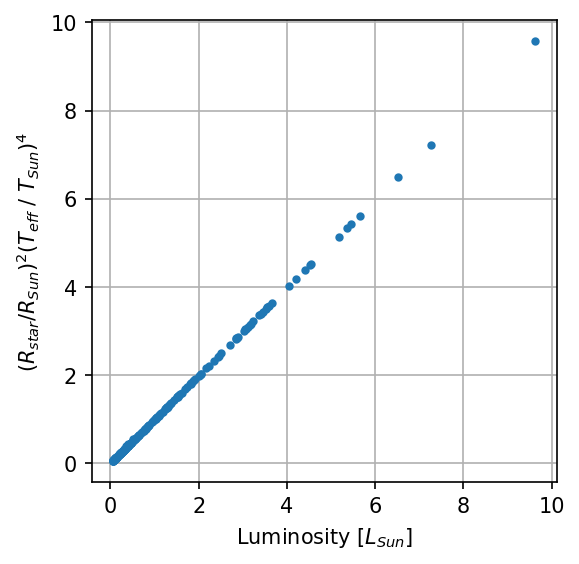

In [88]:
plt.figure(figsize=(4, 4), dpi=150) 
plt.plot(query_dr3['lum_flame'], (query_dr3['teff_gspphot']/5780)**4 * query_dr3['radius_flame']**2, '.')
plt.xlabel('Luminosity [$L_{Sun}$]')
plt.ylabel('$(R_{star}/R_{Sun})^2(T_{eff}$ / $T_{Sun})^4$')
plt.grid()

#### Query Gaia DR2

In [95]:
# Define the ADQL query

# query = """
# SELECT source_id, ra, dec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, parallax, teff_val
# FROM gaiadr2.gaia_source
# WHERE phot_g_mean_mag < 9
#   AND dec BETWEEN -90 AND 60
#   AND parallax >= 50
#   AND (duplicated_source = 'false' OR duplicated_source IS NULL)
#   AND (phot_bp_mean_mag - phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
# """

query = """
SELECT gs.source_id, gs.ra, gs.dec, gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag, gs.parallax, gs.teff_val, ap.mass_flame, ap.lum_flame
FROM gaiadr2.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 9
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 50
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
  AND (gs.phot_bp_mean_mag - gs.phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
  AND ap.mass_flame IS NOT NULL
  AND ap.lum_flame IS NOT NULL
"""

# note: adding the last constrint "ap.mass_flame IS NOT NULL" decreases the number of results from 325 to 172

# Execute the query
job = Gaia.launch_job(query)
query_dr2 = job.get_results()

# Print the results
query_dr2

source_id,ra,dec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,parallax,teff_val,mass_flame,lum_flame
,deg,deg,mag,mag,mag,mas,K,solMass,solLum
int64,float64,float64,float32,float32,float32,float64,float32,float32,float32
4911306239828325760,24.95057933205967,-56.19640157291552,5.6040273,6.110481,5.017446,122.13334113520919,5072.6665,0.7728912,0.31139687
4911306239828325632,24.95125177735008,-56.193253444734914,5.4815745,5.975546,4.9180384,122.05515593526933,5083.0,0.848425,0.3325382
4503794795019024000,282.1223322844829,10.743571121256357,7.5975785,8.204739,6.895321,59.26211802631218,4802.3335,0.74777335,0.23566432
4038724053986441856,271.5993956729909,-36.019748261251586,5.7883286,6.125644,5.3455925,58.12581270135795,5922.0,0.9937225,1.0418576
4912580642524184960,25.623352566889793,-53.74128518649365,5.354947,5.6769776,4.966038,57.655586404793524,6143.0,1.0749273,1.5767086
4623036865373793408,84.29927979496259,-80.4646040515499,5.4906683,5.8385477,5.064284,54.70524180803885,5960.5,1.0258615,1.5354643
1234693112077610880,221.59652203947957,16.492729215598665,8.710161,9.476045,7.900152,56.320803206408755,4253.005,0.64877063,0.112481706
1264630412816366720,226.82615129468738,24.86848696167738,4.757479,5.0543466,4.467854,51.66743878315765,6567.0,1.284035,3.4606323


#### overlapping sources

OK... note that DR2 and DR3 may not share the same source_id, so estimate below is less than what it should be.

In [96]:
# Assuming query_dr3 is already obtained similarly to query_dr2

# Extract the source_id columns from both results
source_ids_dr2 = query_dr2['source_id']
source_ids_dr3 = query_dr3['source_id']

# Find the intersection of source_ids between DR2 and DR3
overlapping_source_ids = set(source_ids_dr2).intersection(set(source_ids_dr3))

# Print the overlapping source_ids
print(f"Number of overlapping source_ids: {len(overlapping_source_ids)}")
print(overlapping_source_ids)


Number of overlapping source_ids: 162
{1244571953471006720, 3575733210781078016, 5835498883232034816, 6171492113110925312, 5760701787150565888, 3865002247461685248, 4634528720388462592, 6018047019138644480, 1359938520253565952, 3724242219117947904, 6471497502884511232, 6009538585839374336, 3478127463341507072, 1605198298364601088, 5160075762132996992, 683184784030475520, 714116137767540096, 3101923001490347392, 5951165616611763456, 4745373133284418816, 746545172372256384, 2920772722738017920, 2904830113367963264, 4503794795019024000, 2473608009504466688, 1462061709995883136, 4038724053986441856, 6847167606385195648, 6490470881687779968, 1264630412816366720, 5808612830236138368, 3498481519515679872, 5726982995343100928, 5381537023379295232, 1833199729671740800, 70051608089857536, 4419140645978987904, 777254360337133312, 952326504452337792, 4467355158571184256, 3256786534197166208, 1821708351374312064, 892215482207937152, 2552925644460225152, 3852570413083923072, 4389844948935164544, 646

### 2. List star names and object types

In [6]:
from astroquery.simbad import Simbad
from astroquery.gaia import Gaia

# Customize Simbad to include the HD, GJ, and HIP identifiers and object type
custom_simbad = Simbad()
custom_simbad.add_votable_fields('ids', 'otype')

# Define the ADQL query to get Gaia source IDs
query = """
SELECT source_id, ra, dec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, parallax, teff_gspphot
FROM gaiadr3.gaia_source
WHERE phot_g_mean_mag < 9
  AND dec BETWEEN -90 AND 60
  AND parallax >= 50
  AND (duplicated_source = 'false' OR duplicated_source IS NULL)
  AND (phot_bp_mean_mag - phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
"""

# Execute the query
job = Gaia.launch_job(query)
results = job.get_results()

# Extract Gaia source IDs
source_ids = results['source_id']

# Dictionary to collect object types
object_types_collected = {}

# Query Simbad for each Gaia source ID and filter for HD, GJ, and HIP numbers and object types
for source_id in source_ids:
    result_table = custom_simbad.query_object(f"Gaia DR3 {source_id}")
    if result_table is not None:
        ids = result_table['IDS'][0].split('|')
        hd_numbers = [id.strip() for id in ids if id.startswith('HD')]
        gj_numbers = [id.strip() for id in ids if id.startswith('GJ')]
        hip_numbers = [id.strip() for id in ids if id.startswith('HIP')]
        object_type = result_table['OTYPE'][0]

        # Collect object types
        if object_type not in object_types_collected:
            object_types_collected[object_type] = 0
        object_types_collected[object_type] += 1

        if hd_numbers:
            print(f"Gaia DR3 {source_id}: HD Number(s): {hd_numbers}, Object Type: {object_type}")
        elif gj_numbers:
            print(f"Gaia DR3 {source_id}: GJ Number(s): {gj_numbers}, Object Type: {object_type}")
        elif hip_numbers:
            print(f"Gaia DR3 {source_id}: HIP Number(s): {hip_numbers}, Object Type: {object_type}")
        else:
            print(f"Gaia DR3 {source_id}: No HD, GJ, or HIP number found, Object Type: {object_type}")
    else:
        print(f"No alternative names or object type found for Gaia DR3 {source_id}")

# Print all collected object types
print("\nCollected Object Types:")
for object_type, count in object_types_collected.items():
    print(f"{object_type}: {count}")


Gaia DR3 4683897617110115200: HD Number(s): ['HD   2151'], Object Type: HighPM*
Gaia DR3 5698015743046182272: HD Number(s): ['HD  67523'], Object Type: delSctV*
Gaia DR3 5826168461855385472: HD Number(s): ['HD 141891'], Object Type: HighPM*
Gaia DR3 6838311796136238976: HD Number(s): ['HD 207098'], Object Type: SB*
Gaia DR3 4269932382607207040: HD Number(s): ['HD 168723'], Object Type: HighPM*
Gaia DR3 1018776176872261248: HD Number(s): ['HD  82328'], Object Type: HighPM*
Gaia DR3 3288921720025503360: HD Number(s): ['HD  30652'], Object Type: HighPM*
Gaia DR3 1014058103758571520: GJ Number(s): ['GJ 331.0', 'GJ 331 A'], Object Type: SB*
Gaia DR3 5849837854861497856: HD Number(s): ['HD 128898'], Object Type: alf2CVnV*
Gaia DR3 4594497769766809216: HD Number(s): ['HD 161797', 'HD 161797A'], Object Type: **
Gaia DR3 3352485999058854912: HD Number(s): ['HD  48737'], Object Type: HighPM*
Gaia DR3 5164120762333028736: HD Number(s): ['HD  23249'], Object Type: HighPM*
Gaia DR3 2452378776434477


HighPM*: High Proper Motion Star. These stars have significant movement across the sky relative to more distant stars, indicating they are relatively close to Earth.

delSctV*: Delta Scuti Variable Star. These are pulsating variables with short periods of light variation, typically less than 0.3 days, found in the instability strip of the Hertzsprung-Russell diagram.

SB*: Spectroscopic Binary. A binary star system in which the stars are too close to be resolved individually but can be detected through their spectral lines.

alf2CVnV*: Alpha2 Canum Venaticorum Variable Star. These are chemically peculiar stars with strong magnetic fields and spectral lines that vary with the star's rotation.

**: Double or Multiple Star. A system of two or more stars that are gravitationally bound to each other.

BYDraV*: BY Draconis Variable Star. These are main-sequence variable stars showing light variations due to rotational modulation of star spots.

Variable*: Variable Star. A star whose brightness as seen from Earth fluctuates.

Eruptive*: Eruptive Variable Star. Stars that show sudden changes in brightness due to eruptions or flares.

RotV*: Rotational Variable Star. Stars whose brightness variations are due to rotation.

RSCVnV*: RS Canum Venaticorum Variable Star. These are close binary stars with active chromospheres, showing variations due to star spots and eclipses.

RGB*: Red Giant Branch Star. A star in a late phase of stellar evolution, characterized by expansion and cooling of the outer layers.

TTauri*: T Tauri Star. A very young star still in the process of gravitational contraction, often surrounded by a protoplanetary disk.

Star: A self-luminous celestial body consisting of a mass of gas held together by its own gravity.

EclBin: Eclipsing Binary. A binary star system where the orbital plane is aligned with our line of sight, causing the stars to eclipse each other.

Low-Mass*: Low-Mass Star. A star with a mass lower than approximately 0.5 solar masses, often including red dwarfs.

ChemPec*: Chemically Peculiar Star. Stars with unusual abundances of certain elements in their atmospheres.

### 3. Export to Excel

#### DR3

In [108]:
import pandas as pd
from astroquery.simbad import Simbad
from astroquery.gaia import Gaia
from openpyxl import load_workbook

# Customize Simbad to include the HD, GJ, and HIP identifiers and object type
custom_simbad = Simbad()
custom_simbad.add_votable_fields('ids', 'otype')

# Define the ADQL query to get Gaia source IDs
# query = """
# SELECT source_id, ra, dec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, parallax, teff_gspphot
# FROM gaiadr3.gaia_source
# WHERE phot_g_mean_mag < 9
#   AND dec BETWEEN -90 AND 60
#   AND parallax >= 50
#   AND (duplicated_source = 'false' OR duplicated_source IS NULL)
#   AND (phot_bp_mean_mag - phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
# """

query = """
SELECT gs.source_id, gs.ra, gs.dec, gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag, gs.bp_rp, gs.parallax, gs.teff_gspphot, ap.mass_flame, ap.lum_flame, ap.radius_flame
FROM gaiadr3.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 9
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 50
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
  AND (gs.phot_bp_mean_mag - gs.phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
  AND ap.mass_flame IS NOT NULL
  AND ap.lum_flame IS NOT NULL
  AND ap.radius_flame IS NOT NULL
"""

# Execute the query
job = Gaia.launch_job(query)
results = job.get_results()

# Extract Gaia source IDs
source_ids = results['source_id']

# Initialize lists to store data
data = {
    'Gaia DR3 Source ID': [],
    'RA': [],
    'DEC': [],
    'Phot G Mean Mag': [],
    'Phot BP Mean Mag': [],
    'Phot RP Mean Mag': [],
    'Parallax': [],
    'Teff': [],
    'Stellar Mass': [],
    'Luminosity': [],
    'Radius': [],
    'HD Number': [],
    'GJ Number': [],
    'HIP Number': [],
    'Object Type': []
}

# Query Simbad for each Gaia source ID and filter for HD, GJ, and HIP numbers and object types
for source_id in source_ids:
    result_table = custom_simbad.query_object(f"Gaia DR3 {source_id}")
    hd_numbers = []
    gj_numbers = []
    hip_numbers = []
    object_type = None
    
    if result_table is not None:
        ids = result_table['IDS'][0].split('|')
        hd_numbers = [id.strip() for id in ids if id.startswith('HD')]
        gj_numbers = [id.strip() for id in ids if id.startswith('GJ')]
        hip_numbers = [id.strip() for id in ids if id.startswith('HIP')]
        object_type = result_table['OTYPE'][0]

    data['Gaia DR3 Source ID'].append(str(source_id))  # Convert source_id to string
    data['RA'].append(results['ra'][source_ids == source_id][0])
    data['DEC'].append(results['dec'][source_ids == source_id][0])
    data['Phot G Mean Mag'].append(results['phot_g_mean_mag'][source_ids == source_id][0])
    data['Phot BP Mean Mag'].append(results['phot_bp_mean_mag'][source_ids == source_id][0])
    data['Phot RP Mean Mag'].append(results['phot_rp_mean_mag'][source_ids == source_id][0])
    data['Parallax'].append(results['parallax'][source_ids == source_id][0])
    data['Teff'].append(results['teff_gspphot'][source_ids == source_id][0])
    data['Stellar Mass'].append(results['mass_flame'][source_ids == source_id][0])
    data['Luminosity'].append(results['lum_flame'][source_ids == source_id][0])
    data['Radius'].append(results['radius_flame'][source_ids == source_id][0])
    data['HD Number'].append(', '.join(hd_numbers) if hd_numbers else None)
    data['GJ Number'].append(', '.join(gj_numbers) if gj_numbers else None)
    data['HIP Number'].append(', '.join(hip_numbers) if hip_numbers else None)
    data['Object Type'].append(object_type)

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data)

# Export the DataFrame to an Excel file
directory = '../results/'
excel_file = 'query_dr3.xlsx'
output_path = directory + excel_file
df.to_excel(output_path, index=False)

# Load the workbook and select the active worksheet
workbook = load_workbook(output_path)
worksheet = workbook.active

# Adjust the column widths
adjust_column_widths(output_path)


In [109]:
result_table = custom_simbad.query_object(f"Gaia DR3 {source_ids[0]}")
result_table

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,IDS,OTYPE,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,object,object,int32
* pi.03 Ori,04 49 50.4112,+06 57 40.600,14,14,0.168,0.087,90,A,O,2020yCat.1350....0G,LTT 11517|* 1 Ori|* pi.03 Ori|** STT 560A|ASCC 1010229|BD+06 762|CCDM J04499+0657A|Ci 20 306|CNS5 1208|CSI+06 762 1|CSV 100411|1ES 0447+06.8|2EUVE J0449+06.9|EUVE J0449+06.9|FK5 1134|GC 5875|GCRV 2837|GEN# +1.00030652|GJ 178|HD 30652|HIC 22449|HIP 22449|HR 1543|IDS 04444+0647 A|IRAS 04471+0652|IRC +10071|JP11 931|LSPM J0449+0657|2MASS J04495040+0657409|N30 1028|NAME Tabit|NLTT 14011|NSV 1731|PLX 1077|PLX 1077.00|PMC 90-93 758|PPM 148020|RAVE J044950.4+065741|2RE J044951+065736|2RE J0449+065|RE J0449+065|RE J044950+065733|ROT 683|1RXS J044950.6+065736|SAO 112106|SKY# 7512|SPOCS 230|SRS 31134|SV* ZI 311|TD1 3592|TIC 399665349|TYC 96-1462-1|UBV 4635|UBV M 10360|USNO-B1.0 0969-00046662|USNO 809|uvby98 100030652|WDS J04498+0658A|WEB 4331|YZ 6 1810|Zkh 65|Gaia DR2 3288921720024442496|Gaia DR3 3288921720025503360,HighPM*,1


In [110]:
if result_table is not None:
    ids = result_table['IDS'][0].split('|')
    hd_numbers = [id.strip() for id in ids if id.startswith('HD')]
    gj_numbers = [id.strip() for id in ids if id.startswith('GJ')]
    hip_numbers = [id.strip() for id in ids if id.startswith('HIP')]
    object_type = result_table['OTYPE'][0]

hd_numbers, gj_numbers, hip_numbers, object_type

(['HD  30652'], ['GJ 178'], ['HIP 22449'], 'HighPM*')

#### DR2

In [112]:
import pandas as pd
from astroquery.simbad import Simbad
from astroquery.gaia import Gaia
from openpyxl import load_workbook

# Customize Simbad to include the HD, GJ, and HIP identifiers and object type
custom_simbad = Simbad()
custom_simbad.add_votable_fields('ids', 'otype')

# Define the ADQL query for Gaia DR2
# query_dr2 = """
# SELECT source_id, ra, dec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, parallax, teff_val
# FROM gaiadr2.gaia_source
# WHERE phot_g_mean_mag < 9
#   AND dec BETWEEN -90 AND 60
#   AND parallax >= 50
#   AND (duplicated_source = 'false' OR duplicated_source IS NULL)
#   AND (phot_bp_mean_mag - phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
# """

query_dr2 = """
SELECT gs.source_id, gs.ra, gs.dec, gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag, gs.parallax, gs.teff_val, ap.mass_flame, ap.lum_flame, ap.radius_flame
FROM gaiadr2.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 9
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 50
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
  AND (gs.phot_bp_mean_mag - gs.phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
  AND ap.mass_flame IS NOT NULL
  AND ap.lum_flame IS NOT NULL
  AND ap.radius_flame IS NOT NULL
"""

# Execute the query for DR2
job_dr2 = Gaia.launch_job(query_dr2)
query_dr2 = job_dr2.get_results()

# Extract Gaia source IDs for DR2
source_ids_dr2 = query_dr2['source_id']

# Initialize lists to store data for DR2
data_dr2 = {
    'Gaia DR2 Source ID': [],
    'RA': [],
    'DEC': [],
    'Phot G Mean Mag': [],
    'Phot BP Mean Mag': [],
    'Phot RP Mean Mag': [],
    'Parallax': [],
    'Teff': [],
    'Stellar Mass': [],
    'Luminosity': [],
    'Radius': [],
    'HD Number': [],
    'GJ Number': [],
    'HIP Number': [],
    'Object Type': []
}

# Query Simbad for each Gaia source ID in DR2 and filter for HD, GJ, and HIP numbers and object types
for source_id in source_ids_dr2:
    result_table = custom_simbad.query_object(f"Gaia DR2 {source_id}")
    hd_numbers = []
    gj_numbers = []
    hip_numbers = []
    object_type = None
    
    if result_table is not None:
        ids = result_table['IDS'][0].split('|')
        hd_numbers = [id.strip() for id in ids if id.startswith('HD')]
        gj_numbers = [id.strip() for id in ids if id.startswith('GJ')]
        hip_numbers = [id.strip() for id in ids if id.startswith('HIP')]
        object_type = result_table['OTYPE'][0]

    data_dr2['Gaia DR2 Source ID'].append(str(source_id))  # Convert source_id to string
    data_dr2['RA'].append(query_dr2['ra'][source_ids_dr2 == source_id][0])
    data_dr2['DEC'].append(query_dr2['dec'][source_ids_dr2 == source_id][0])
    data_dr2['Phot G Mean Mag'].append(query_dr2['phot_g_mean_mag'][source_ids_dr2 == source_id][0])
    data_dr2['Phot BP Mean Mag'].append(query_dr2['phot_bp_mean_mag'][source_ids_dr2 == source_id][0])
    data_dr2['Phot RP Mean Mag'].append(query_dr2['phot_rp_mean_mag'][source_ids_dr2 == source_id][0])
    data_dr2['Parallax'].append(query_dr2['parallax'][source_ids_dr2 == source_id][0])
    data_dr2['Teff'].append(query_dr2['teff_val'][source_ids_dr2 == source_id][0])
    data_dr2['Stellar Mass'].append(query_dr2['mass_flame'][source_ids_dr2 == source_id][0])
    data_dr2['Luminosity'].append(query_dr2['lum_flame'][source_ids_dr2 == source_id][0])
    data_dr2['Radius'].append(query_dr2['radius_flame'][source_ids_dr2 == source_id][0])
    data_dr2['HD Number'].append(', '.join(hd_numbers) if hd_numbers else None)
    data_dr2['GJ Number'].append(', '.join(gj_numbers) if gj_numbers else None)
    data_dr2['HIP Number'].append(', '.join(hip_numbers) if hip_numbers else None)
    data_dr2['Object Type'].append(object_type)

# Convert the data to a pandas DataFrame for DR2
df_dr2 = pd.DataFrame(data_dr2)

# Export the DataFrame to an Excel file for DR2
excel_file_dr2 = 'query_dr2.xlsx'
output_path_dr2 = directory + excel_file_dr2
df_dr2.to_excel(output_path_dr2, index=False)

# Load the workbook and select the active worksheet for DR2
workbook_dr2 = load_workbook(output_path_dr2)
worksheet_dr2 = workbook_dr2.active

# Adjust the column widths for DR2
adjust_column_widths(output_path_dr2)


#### Merging dr2 and dr3

In [136]:
# Load the DR2 and DR3 data from the Excel files
df_dr2 = pd.read_excel(directory + 'query_dr2.xlsx')
df_dr3 = pd.read_excel(directory + 'query_dr3.xlsx')

# Ensure that 'Gaia DR2 Source ID' and 'Gaia DR3 Source ID' are strings
df_dr2['Gaia DR2 Source ID'] = df_dr2['Gaia DR2 Source ID'].astype(str)
df_dr3['Gaia DR3 Source ID'] = df_dr3['Gaia DR3 Source ID'].astype(str)

# Merge the two DataFrames on 'source_id', keeping all entries
merged_df = pd.merge(df_dr2, df_dr3, left_on='Gaia DR2 Source ID', right_on='Gaia DR3 Source ID', suffixes=('_dr2', '_dr3'), how='outer')

# Replace '--' with NaN in the merged DataFrame
merged_df['Teff_dr3'] = merged_df['Teff_dr3'].replace("--", np.nan)
print("Merged DataFrame:")
display(merged_df)

combined_data = {
    'Source ID': merged_df['Gaia DR2 Source ID'].combine_first(merged_df['Gaia DR3 Source ID']).astype(str),
    'RA': merged_df['RA_dr3'].combine_first(merged_df['RA_dr2']),
    'DEC': merged_df['DEC_dr3'].combine_first(merged_df['DEC_dr2']),
    'Phot G Mean Mag': merged_df['Phot G Mean Mag_dr3'].combine_first(merged_df['Phot G Mean Mag_dr2']),
    'Phot BP Mean Mag': merged_df['Phot BP Mean Mag_dr3'].combine_first(merged_df['Phot BP Mean Mag_dr2']),
    'Phot RP Mean Mag': merged_df['Phot RP Mean Mag_dr3'].combine_first(merged_df['Phot RP Mean Mag_dr2']),
    'Parallax': merged_df['Parallax_dr3'].combine_first(merged_df['Parallax_dr2']),
    'Teff': merged_df['Teff_dr3'].combine_first(merged_df['Teff_dr2']),
    'Stellar Mass': merged_df['Stellar Mass_dr3'].combine_first(merged_df['Stellar Mass_dr2']),
    'Luminosity': merged_df['Luminosity_dr3'].combine_first(merged_df['Luminosity_dr2']),
    'Radius': merged_df['Radius_dr3'].combine_first(merged_df['Radius_dr2']),
    'HD Number': merged_df['HD Number_dr3'].combine_first(merged_df['HD Number_dr2']),
    'GJ Number': merged_df['GJ Number_dr3'].combine_first(merged_df['GJ Number_dr2']),
    'HIP Number': merged_df['HIP Number_dr3'].combine_first(merged_df['HIP Number_dr2']),
    'Object Type': merged_df['Object Type_dr3'].combine_first(merged_df['Object Type_dr2']),
}

# Convert the combined data into a DataFrame
combined_df = pd.DataFrame(combined_data)

Merged DataFrame:


,Gaia DR2 Source ID,RA_dr2,DEC_dr2,Phot G Mean Mag_dr2,Phot BP Mean Mag_dr2,Phot RP Mean Mag_dr2,Parallax_dr2,Teff_dr2,Stellar Mass_dr2,Luminosity_dr2,...,Phot RP Mean Mag_dr3,Parallax_dr3,Teff_dr3,Stellar Mass_dr3,Luminosity_dr3,Radius_dr3,HD Number_dr3,GJ Number_dr3,HIP Number_dr3,Object Type_dr3
0,4911306239828325760,24.950579,-56.196402,5.604027,6.110481,5.017446,122.133341,5072.666504,0.772891,0.311397,...,4.995800,122.003472,4902.265137,0.772891,0.311397,0.773601,HD 10361,GJ 66 A,NaN,HighPM*
1,4911306239828325632,24.951252,-56.193253,5.481575,5.975546,4.918038,122.055156,5083.000000,0.848425,0.332538,...,4.886207,122.108813,5044.240234,0.848425,0.332538,0.755049,HD 10360,GJ 66 B,NaN,HighPM*
2,4503794795019024000,282.122332,10.743571,7.597579,8.204739,6.895321,59.262118,4802.333496,0.747773,0.235664,...,6.885082,59.234454,4542.218750,0.747773,0.235664,0.783907,HD 174080,GJ 727,HIP 92283,HighPM*
3,4038724053986441856,271.599396,-36.019748,5.788329,6.125644,5.345592,58.125813,5922.000000,0.993722,1.041858,...,5.326963,58.429633,5773.397461,0.993722,1.041858,1.020187,HD 165185,GJ 702.1,HIP 88694,HighPM*
4,4912580642524184960,25.623353,-53.741285,5.354947,5.676978,4.966038,57.655586,6143.000000,1.074927,1.576709,...,4.946809,57.640899,6011.648926,1.074927,1.576709,1.157568,HD 10647,GJ 3109,HIP 7978,HighPM*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.115734,56.556967,5304.386230,0.831084,0.500709,0.878492,HD 21175,GJ 3222,HIP 15799,HighPM*
224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.329168,57.865912,5015.698730,0.813205,0.402590,0.840273,HD 67199,GJ 3476,HIP 39342,HighPM*
225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.398603,53.052628,5230.245605,0.866382,0.455258,0.821747,HD 4747,GJ 36,HIP 3850,SB*
226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.031435,100.916060,3760.628174,0.605965,0.079379,0.663517,HD 232979,GJ 172,HIP 21553,Eruptive*


Gaia only provides B, R and G-band magnitudes, but the RV precision tool uses the V-band magnitudes. I've found a conversion from this paper <https://iopscience.iop.org/article/10.3847/2041-8213/aacdf6/pdf> (Table 2) from Gaia DR2, which should also work for Gaia DR3.

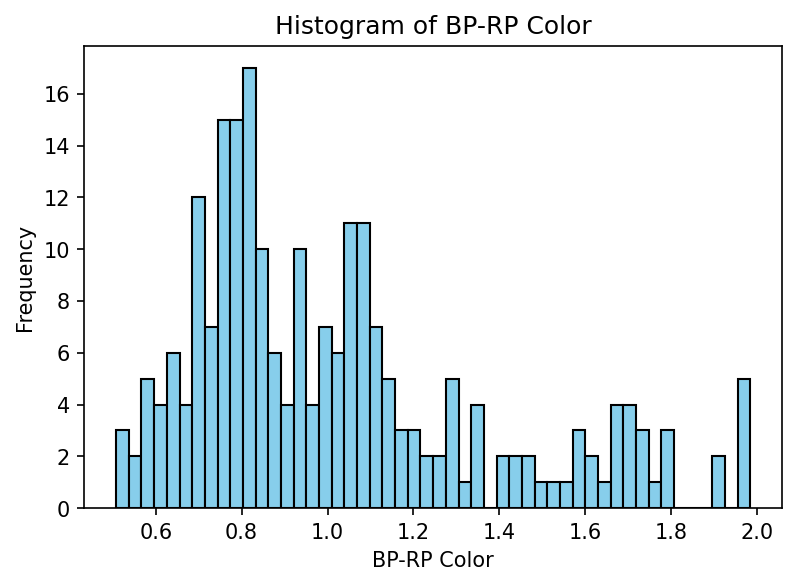

In [137]:
color = combined_df['Phot BP Mean Mag'] - combined_df['Phot RP Mean Mag']


# Create a high-resolution plot
plt.figure(figsize=(6, 4), dpi=150)  # Set the dpi to 300 for high resolution
plt.hist(color, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('BP-RP Color')
plt.ylabel('Frequency')
plt.title('Histogram of BP-RP Color')

plt.show()

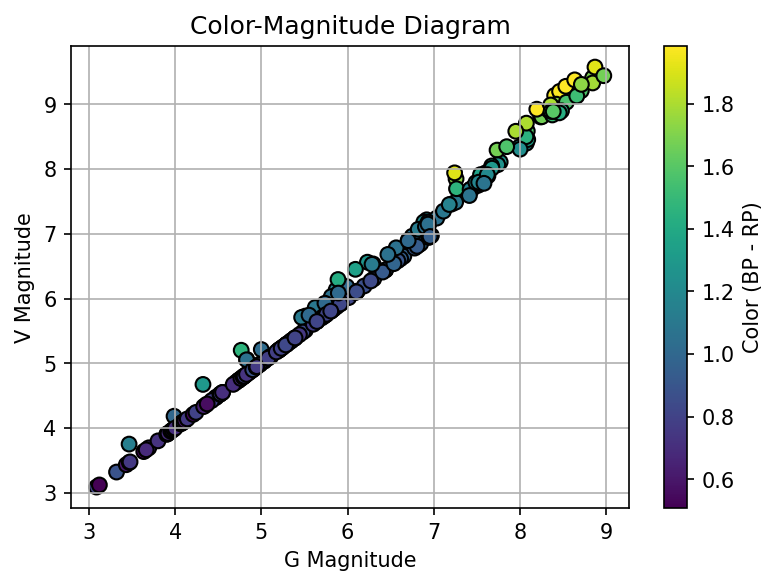

In [138]:

# Assuming 'color' is a column in combined_df or an array of the same length as the DataFrame
# For example, if 'color' is the difference between 'Phot BP Mean Mag' and 'Phot RP Mean Mag'
color = combined_df['Phot BP Mean Mag'] - combined_df['Phot RP Mean Mag']

# Calculate the conversion factor for colors between 1 and 4
conv = 0.20220 + 0.02489 * color

# Use np.where to apply the conversion conditionally
V_mag = np.where((color >= 1) & (color <= 4),
                 combined_df['Phot BP Mean Mag'] - conv,
                 combined_df['Phot G Mean Mag'])

# Create a high-resolution plot
plt.figure(figsize=(6, 4), dpi=150)  # Set the dpi to 300 for high resolution

# Plot the diagram using the color array for point colors
plt.scatter(combined_df['Phot G Mean Mag'], V_mag, c=color, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('G Magnitude')
plt.ylabel('V Magnitude')
plt.title('Color-Magnitude Diagram')
plt.colorbar(label='Color (BP - RP)')
plt.grid()
plt.show()


In [139]:
combined_df

,Source ID,RA,DEC,Phot G Mean Mag,Phot BP Mean Mag,Phot RP Mean Mag,Parallax,Teff,Stellar Mass,Luminosity,Radius,HD Number,GJ Number,HIP Number,Object Type
0,4911306239828325760,24.950657,-56.196400,5.625487,6.089998,4.995800,122.003472,4902.265137,0.772891,0.311397,0.773601,HD 10361,GJ 66 A,NaN,HighPM*
1,4911306239828325632,24.951317,-56.193251,5.508302,5.956992,4.886207,122.108813,5044.240234,0.848425,0.332538,0.755049,HD 10360,GJ 66 B,NaN,HighPM*
2,4503794795019024000,282.122350,10.743510,7.606561,8.177541,6.885082,59.234454,4542.218750,0.747773,0.235664,0.783907,HD 174080,GJ 727,HIP 92283,HighPM*
3,4038724053986441856,271.599414,-36.019747,5.805398,6.107953,5.326963,58.429633,5773.397461,0.993722,1.041858,1.020187,HD 165185,GJ 702.1,HIP 88694,HighPM*
4,4912580642524184960,25.623392,-53.741300,5.383109,5.657312,4.946809,57.640899,6011.648926,1.074927,1.576709,1.157568,HD 10647,GJ 3109,HIP 7978,HighPM*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,4852870701505115904,50.897269,-40.076223,6.703753,7.120555,6.115734,56.556967,5304.386230,0.831084,0.500709,0.878492,HD 21175,GJ 3222,HIP 15799,HighPM*
224,5274724279107404544,120.628218,-66.021521,6.934041,7.377774,6.329168,57.865912,5015.698730,0.813205,0.402590,0.840273,HD 67199,GJ 3476,HIP 39342,HighPM*
225,2348830516542653824,12.364012,-23.211912,6.957821,7.347584,6.398603,53.052628,5230.245605,0.866382,0.455258,0.821747,HD 4747,GJ 36,HIP 3850,SB*
226,272855565763652480,69.422784,52.891503,7.952531,8.829921,7.031435,100.916060,3760.628174,0.605965,0.079379,0.663517,HD 232979,GJ 172,HIP 21553,Eruptive*


In [140]:
# Insert the 'V_mag' column right after the 'DEC' column
combined_df.insert(combined_df.columns.get_loc('DEC') + 1, 'V_mag', V_mag)

if 'Teff' in combined_df.columns:

    # Calculate the HZ_limit
    hz_limits = combined_df.apply(lambda row: calculate_habitable_zone(row['Teff'], row['Luminosity']), axis=1)
    # Find the index of the 'Radius' column
    radius_index = combined_df.columns.get_loc('Radius')
    # Insert the new column after 'Radius'
    combined_df.insert(radius_index + 1, 'HZ_limit [AU]', hz_limits)

# Export the combined DataFrame to an Excel file
combined_excel_file = 'combined_query.xlsx'
output_path = directory + combined_excel_file
combined_df.to_excel(output_path, index=False)

print(f"Combined results saved to {output_path}")
display(combined_df.head())

# Adjust the column widths
adjust_column_widths(output_path)

Combined results saved to ../results/combined_query.xlsx


,Source ID,RA,DEC,V_mag,Phot G Mean Mag,Phot BP Mean Mag,Phot RP Mean Mag,Parallax,Teff,Stellar Mass,Luminosity,Radius,HZ_limit [AU],HD Number,GJ Number,HIP Number,Object Type
0,4911306239828325760,24.950657,-56.196400,5.860563,5.625487,6.089998,4.995800,122.003472,4902.265137,0.772891,0.311397,0.773601,0.572176,HD 10361,GJ 66 A,NaN,HighPM*
1,4911306239828325632,24.951317,-56.193251,5.728140,5.508302,5.956992,4.886207,122.108813,5044.240234,0.848425,0.332538,0.755049,0.587098,HD 10360,GJ 66 B,NaN,HighPM*
2,4503794795019024000,282.122350,10.743510,7.943171,7.606561,8.177541,6.885082,59.234454,4542.218750,0.747773,0.235664,0.783907,0.505635,HD 174080,GJ 727,HIP 92283,HighPM*
3,4038724053986441856,271.599414,-36.019747,5.805398,5.805398,6.107953,5.326963,58.429633,5773.397461,0.993722,1.041858,1.020187,0.995960,HD 165185,GJ 702.1,HIP 88694,HighPM*
4,4912580642524184960,25.623392,-53.741300,5.383109,5.383109,5.657312,4.946809,57.640899,6011.648926,1.074927,1.576709,1.157568,1.206819,HD 10647,GJ 3109,HIP 7978,HighPM*


### 4. Generate the parameter file

In [141]:
import pandas as pd

# Create a new DataFrame for parameter_file.csv
parameter_df = pd.DataFrame({
    'Name': combined_df['Source ID'],
    'SpT': '',  # Empty column for SpT
    'Temperature': combined_df['Teff'],
    'Vmag': combined_df['V_mag'],
    'Jmag': ''  # Empty column for Jmag
})

# Save the new DataFrame to a CSV file
output_path = directory + 'parameter_file.csv'
parameter_df.to_csv(output_path, index=False)

print(f"Parameter file has been saved as '{output_path}'")

# Display the first few rows of the new DataFrame
parameter_df.head()


Parameter file has been saved as '../results/parameter_file.csv'


,Name,SpT,Temperature,Vmag,Jmag
0,4911306239828325760,,4902.265137,5.860563,
1,4911306239828325632,,5044.240234,5.728140,
2,4503794795019024000,,4542.218750,7.943171,
3,4038724053986441856,,5773.397461,5.805398,
4,4912580642524184960,,6011.648926,5.383109,


### Now go and retrive the RV precision from Reiners' tool 
.

.

.


### Merge RV_prec into query

In [142]:
# Read the CSV file
df_csv = pd.read_csv(directory + 'output.csv', dtype={'Id': str})

# Merge the dataframes based on the ID columns
merged_df = pd.merge(combined_df, df_csv[['Id', 'RV_Prec(370 - 890)']], left_on='Source ID', right_on='Id', how='outer')

# Clean up and rename columns
merged_df = merged_df.drop(columns=['Id'])
merged_df = merged_df.rename(columns={'RV_Prec(370 - 890)': 'RV precision [m/s]'})

# Reorder columns to put "RV precision" next to "HZ_limit [AU]"
cols        = merged_df.columns.tolist()
hz_index    = cols.index("HZ_limit [AU]")
cols.insert(hz_index + 1, cols.pop(cols.index("RV precision [m/s]")))
merged_df   = merged_df[cols]

# Save the updated Excel file
output_path = directory + 'combined_query_with_RV_precision.xlsx'
merged_df.to_excel(output_path, index=False)

# Adjust the column widths
adjust_column_widths(output_path)

print(f"Updated Excel file has been saved as '{output_path}'")


Updated Excel file has been saved as '../results/combined_query_with_RV_precision.xlsx'


### Calculate the HZ mass detection limit

In [143]:
from scipy import optimize

def calculate_planet_mass(K, stellar_mass, orbital_radius):
    """
    Calculate the planet mass based on RV semi-amplitude, stellar mass, and orbital radius,
    assuming an inclination of 90 degrees.
    
    :param K: RV semi-amplitude in m/s
    :param stellar_mass: Mass of the star in kg
    :param orbital_radius: Orbital radius (semi-major axis) in meters
    :return: Mass of the planet in kg
    """
    G = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2
    
    def equation(m_p):
        return K - (G**(1/2) * orbital_radius**(-1/2) * m_p * (stellar_mass + m_p)**(-1/2))
    
    # Use numerical method to solve the equation
    planet_mass = optimize.brentq(equation, 0, stellar_mass)
    
    return planet_mass


In [146]:
# Example usage:
K = 0.09  # m/s
stellar_mass = 1.989e30  # Mass of Sun in kg
orbital_radius = 1.496e11  # 1 AU in meters

# Calculate planet mass
planet_mass = calculate_planet_mass(K, stellar_mass, orbital_radius)
print(f"Planet mass: {planet_mass:.2e} kg")
print(f"Planet mass in Earth masses: {planet_mass / 5.972e24:.2f}")
print(f"Planet mass in Jupiter masses: {planet_mass / 1.898e27:.2f}")

Planet mass: 6.01e+24 kg
Planet mass in Earth masses: 1.01
Planet mass in Jupiter masses: 0.00


In [145]:
from scipy import optimize

# Constants
G = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2
M_earth = 5.97e24  # Earth mass in kg
M_sun = 1.989e30  # Solar mass in kg
AU = 1.496e11  # 1 AU in meters

def calculate_hz_detection_limit(K, stellar_mass, orbital_radius):
    """
    Calculate the minimum detectable planet mass in the Habitable Zone.
    
    :param K: RV precision in m/s
    :param stellar_mass: Mass of the star in solar masses
    :param orbital_radius: Orbital radius (HZ limit) in AU
    :return: Minimum detectable planet mass in Earth masses or np.nan if calculation fails
    """
    try:
        stellar_mass_kg = stellar_mass * M_sun
        orbital_radius_m = orbital_radius * AU
        
        if K <= 0 or stellar_mass_kg <= 0 or orbital_radius_m <= 0:
            return np.nan
        
        def equation(m_p):
            return K - (G**(1/2) * orbital_radius_m**(-1/2) * m_p * (stellar_mass_kg + m_p)**(-1/2))
        
        # Use numerical method to solve the equation
        planet_mass_kg = optimize.brentq(equation, 0, stellar_mass_kg)
        
        return planet_mass_kg / M_earth
    except:
        return np.nan

# Apply the calculation to each row
merged_df['HZ Detection Limit [Earth Mass]'] = merged_df.apply(
    lambda row: calculate_hz_detection_limit(
        row['RV precision [m/s]'],
        row['Stellar Mass'],
        row['HZ_limit [AU]']
    ),
    axis=1
)

# Print some statistics about the new column
print(merged_df['HZ Detection Limit [Earth Mass]'].describe())

# Count and print the number of NaN values
nan_count = merged_df['HZ Detection Limit [Earth Mass]'].isna().sum()
print(f"Number of NaN values: {nan_count}")

# Reorder the columns to place the new column next to 'Mass'
cols = merged_df.columns.tolist()
mass_index = cols.index('RV precision [m/s]')
cols.insert(mass_index + 1, cols.pop(cols.index('HZ Detection Limit [Earth Mass]')))
merged_df = merged_df[cols]

# Save the updated DataFrame
output_path = directory + 'combined_query_with_mass_detection_limit.xlsx'
merged_df.to_excel(output_path, index=False)

# Adjust the column widths
adjust_column_widths(output_path)

print(f"Updated DataFrame saved to '{output_path}'.")


count    227.000000
mean      16.377061
std       37.522165
min        0.696548
25%        2.381286
50%        3.801845
75%        6.296546
max      235.822880
Name: HZ Detection Limit [Earth Mass], dtype: float64
Number of NaN values: 1
Updated DataFrame saved to '../results/combined_query_with_mass_detection_limit.xlsx'.


### Statistics and plots

In [146]:
merged_df.head()

,Source ID,RA,DEC,V_mag,Phot G Mean Mag,Phot BP Mean Mag,Phot RP Mean Mag,Parallax,Teff,Stellar Mass,Luminosity,Radius,HZ_limit [AU],RV precision [m/s],HZ Detection Limit [Earth Mass],HD Number,GJ Number,HIP Number,Object Type
0,4911306239828325760,24.950657,-56.196400,5.860563,5.625487,6.089998,4.995800,122.003472,4902.265137,0.772891,0.311397,0.773601,0.572176,0.332055,2.469687,HD 10361,GJ 66 A,NaN,HighPM*
1,4911306239828325632,24.951317,-56.193251,5.728140,5.508302,5.956992,4.886207,122.108813,5044.240234,0.848425,0.332538,0.755049,0.587098,0.343939,2.714884,HD 10360,GJ 66 B,NaN,HighPM*
2,4503794795019024000,282.122350,10.743510,7.943171,7.606561,8.177541,6.885082,59.234454,4542.218750,0.747773,0.235664,0.783907,0.505635,0.317658,2.184594,HD 174080,GJ 727,HIP 92283,HighPM*
3,4038724053986441856,271.599414,-36.019747,5.805398,5.805398,6.107953,5.326963,58.429633,5773.397461,0.993722,1.041858,1.020187,0.995960,0.494782,5.505255,HD 165185,GJ 702.1,HIP 88694,HighPM*
4,4912580642524184960,25.623392,-53.741300,5.383109,5.383109,5.657312,4.946809,57.640899,6011.648926,1.074927,1.576709,1.157568,1.206819,0.714509,9.101852,HD 10647,GJ 3109,HIP 7978,HighPM*


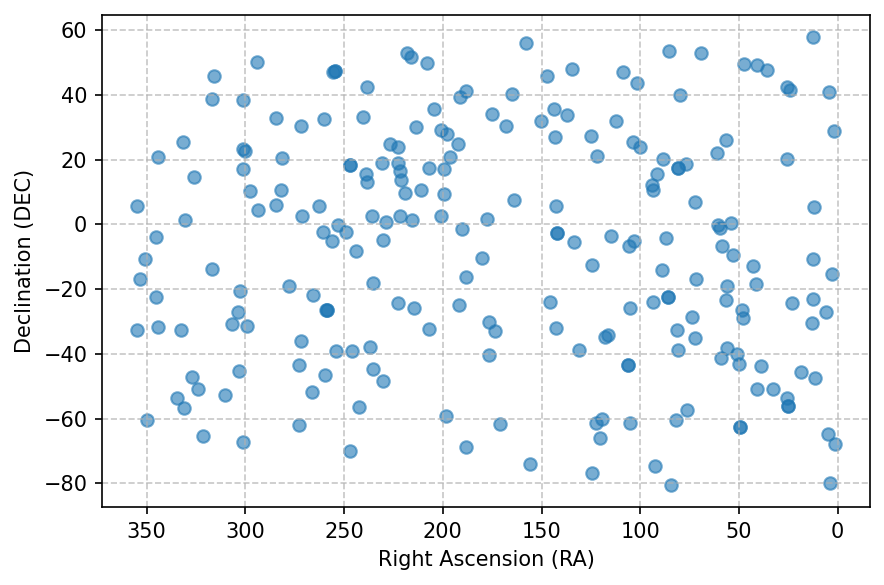

In [147]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4), dpi=150)
plt.scatter(merged_df['RA'], merged_df['DEC'], alpha=0.6)
plt.xlabel('Right Ascension (RA)')
plt.ylabel('Declination (DEC)')
plt.grid(True, linestyle='--', alpha=0.7)

# Invert the x-axis to match astronomical convention (RA increases to the left)
plt.gca().invert_xaxis()

plt.tight_layout()
plt.show()


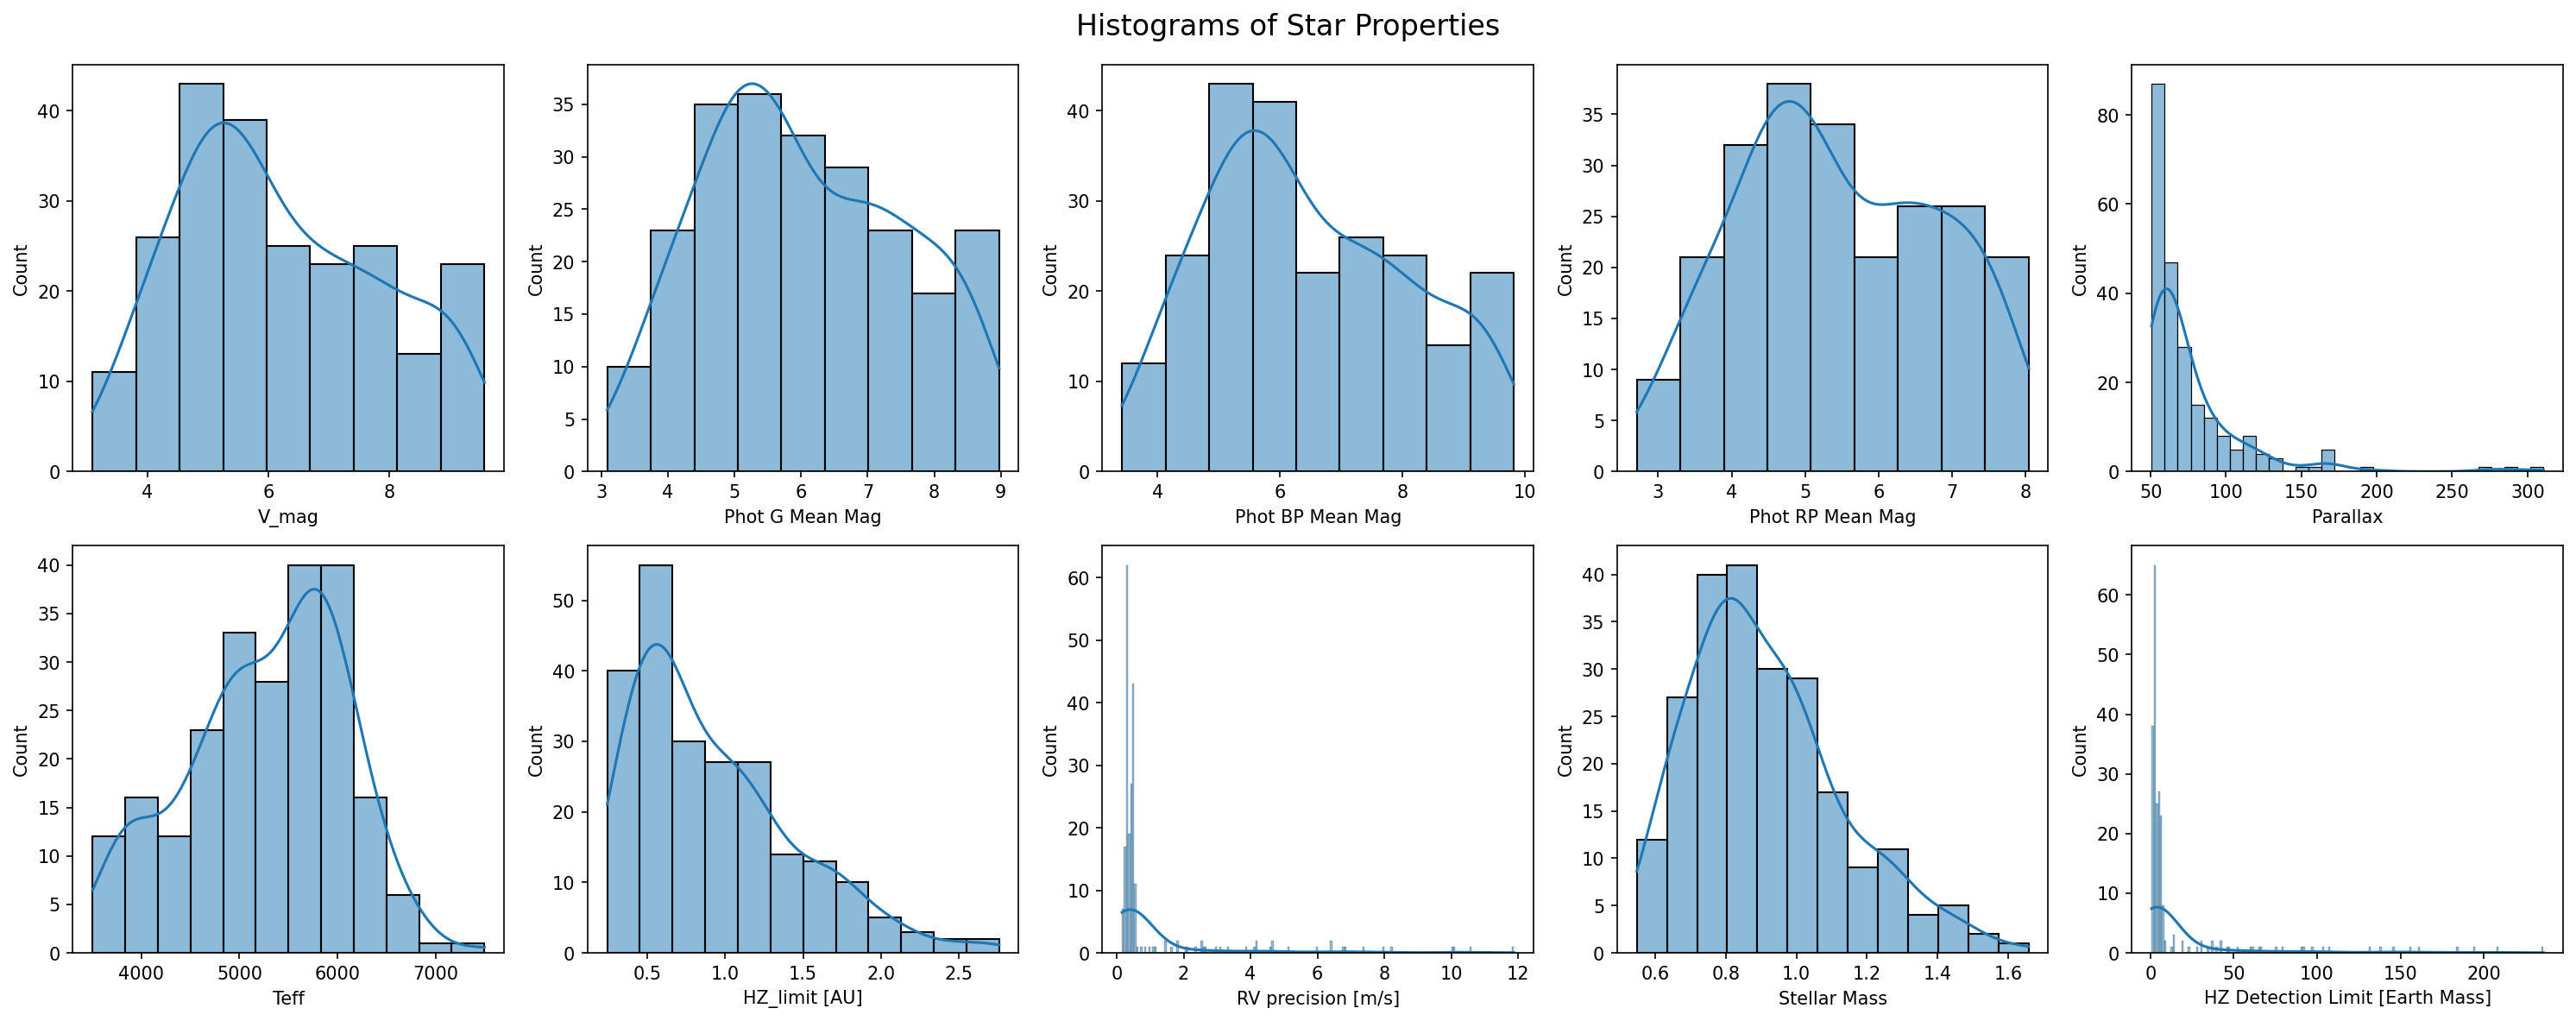

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of columns to plot
columns_to_plot = [
    'V_mag', 'Phot G Mean Mag', 'Phot BP Mean Mag', 'Phot RP Mean Mag',
    'Parallax', 'Teff', 'HZ_limit [AU]', 'RV precision [m/s]',
    'Stellar Mass', 'HZ Detection Limit [Earth Mass]'
]

# Set up the plot
fig, axes = plt.subplots(2, 5, figsize=(20, 8), dpi=150)
fig.suptitle('Histograms of Star Properties', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create histograms
for i, column in enumerate(columns_to_plot):
    sns.histplot(data=merged_df, x=column, kde=True, ax=axes[i])
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')

# Adjust layout and display
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


# additional codes (not used for now)

In [17]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

coord = SkyCoord(ra=280, dec=-60, unit=(u.degree, u.degree), frame='icrs')
width = u.Quantity(0.1, u.deg)
height = u.Quantity(0.1, u.deg)
r = Gaia.query_object_async(coordinate=coord, width=width, height=height)
r
# r.pprint(max_lines=12, max_width=130)

INFO: Query finished. [astroquery.utils.tap.core]


dist,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot
,,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,,,,,,,d,km / s,K,log(cm.s**-2),dex,,km / s,km / s,,mag,mag,,,,deg,deg,deg,deg,,,,,,,,,,,,,,,K,K,K,log(cm.s**-2),log(cm.s**-2),log(cm.s**-2),dex,dex,dex,pc,pc,pc,mag,mag,mag,mag,mag,mag,mag,mag,mag,
float64,int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,fl

In [5]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
from astropy import units as u
from astropy_healpix import HEALPix

In [6]:
# Set input parameters below ===========
DR3            = True            # Set it to False to select EDR3
target_table   = 'gaia_source'   # Alternative values: 'Astrophysical_parameters/astrophysical_parameters/', etc
hpx_level      = 6
lon            =  80.894 * u.deg # Right Ascencion (ICRS)
lat            = -69.756 * u.deg # Declination (ICRS)
radius         = 0.5     * u.deg

print(f'Input Variables: ')
print(f'* HEALPix level                      = {hpx_level} ')
print(f'* ICRS longitude (~ Right Ascension) = {lon} ')
print(f'* ICRS latitude  (~ Declination)     = {lat} ')
print(f'* Radius                             = {radius} ')
print()

Input Variables: 
* HEALPix level                      = 6 
* ICRS longitude (~ Right Ascension) = 80.894 deg 
* ICRS latitude  (~ Declination)     = -69.756 deg 
* Radius                             = 0.5 deg 



In [7]:
# Download basic parameters ============
output_file    = 'bulk_download_files.txt'
output_dir     = 'downloads'

if os.path.isdir(f'{output_dir}'):
    now          = datetime.now()
    output_dir_2 = output_dir + now.strftime("_%Y-%m-%d")
    print(f'>> Warning: {output_dir} directory exist. Creating alternative directory: {output_dir_2}')
    print()
    output_dir   = output_dir_2
else:
    os.system(f'mkdir {output_dir}')

print(f'Files will be downloaded to: {output_dir}')

Files will be downloaded to: downloads
